In [13]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
base_dir = os.path.join("/home/jovyan/work/Corona/COVID-19")
sys.path.append(base_dir)
import model as md

In [14]:
merger = md.Merger(data_dir="data", load_from_raw=False, load_from_agg=True)

In [15]:
# merger.convert_deaths_df()
df = merger.merge_deaths_df()

In [16]:
df.tail()

,Sorszám,Nem,Kor,Alapbetegségek,date
4667,5,F,68,szív és érrendszeri,2020-11-29
4668,4,F,79,szív és érrendszeri,2020-11-29
4669,3,F,74,szív és érrendszeri,2020-11-29
4670,2,N,65,rosszindulatú daganat,2020-11-29
4671,1,N,76,szív és érrendszeri,2020-11-29


In [17]:
df_additional = merger.df["details"][["date","additional.infected"]].set_index("date")

In [18]:
df_tests = merger.show_kpi_hu()[["tests"]].reset_index()
df_tests["index"] = pd.to_datetime(df_tests["index"], format='%Y-%m-%d').dt.date
df_tests["additional.tests"] = df_tests.apply(
    lambda row: row["tests"]-df_tests[
        df_tests["index"]==row["index"] - pd.Timedelta(1, unit='D')
    ]["tests"].max(), 
    axis=1
)
df_tests = df_tests.set_index("index")

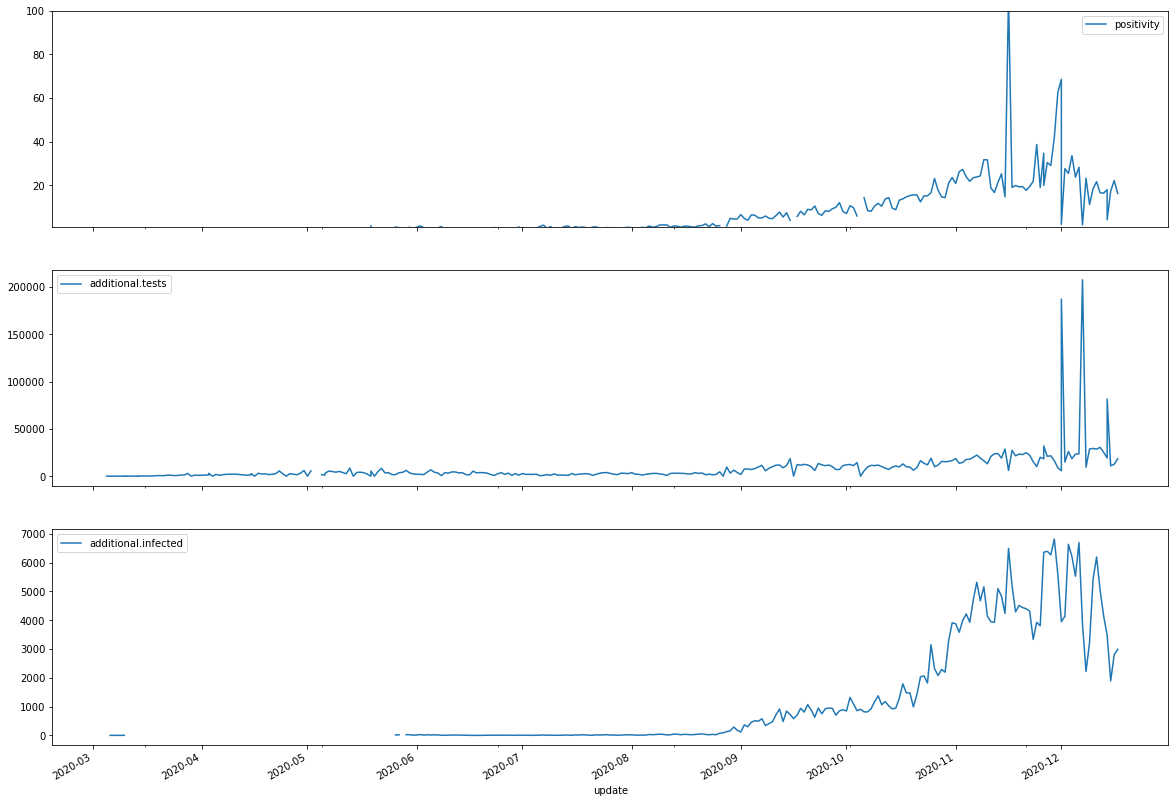

In [19]:
df_join = df_tests.join(df_additional).reset_index()
df_join["positivity"] = df_join["additional.infected"]/df_join["additional.tests"]*100
df_join["Country/Region"] = "HU"
df_join["update"] = df_join["index"]
(fig, ax) = plt.subplots(figsize=(20,15), nrows=3, sharex=True)
ax[0].set_ylim(1,100)
df_join.plot(x="update", y="positivity", ax=ax[0])
df_join.plot(x="update", y="additional.tests", ax=ax[1])
df_join.plot(x="update", y="additional.infected", ax=ax[2])
plt.show()

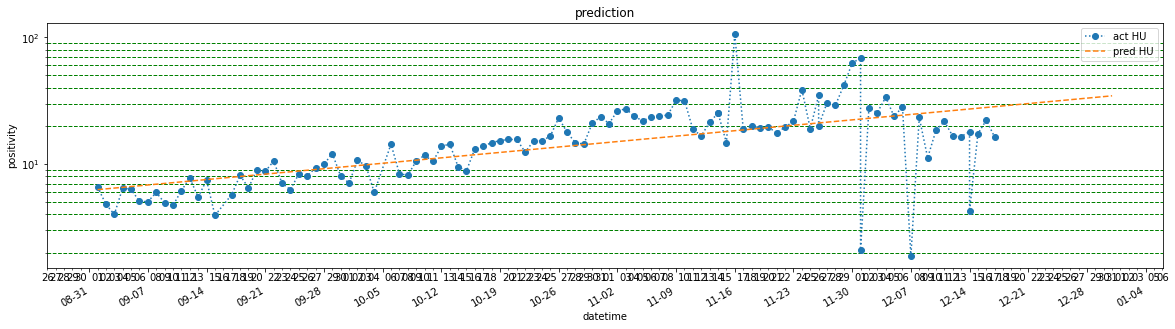

Coefficient of determination: {'HU': 0.4095428919905007}
Evolution factor per day: {'HU': 1.0}
Doubling in day(s): {'HU': 2.0}


,index,tests,additional.tests,additional.infected,positivity,Country/Region,update
324,2020-12-14,2320419.0,19245.0,3470.0,18.030657,HU,2020-12-14
325,2020-12-14,2382632.0,81458.0,3470.0,4.259864,HU,2020-12-14
326,2020-12-15,2393535.0,10903.0,1893.0,17.362194,HU,2020-12-15
327,2020-12-16,2406171.0,12636.0,2804.0,22.190567,HU,2020-12-16
328,2020-12-17,2424533.0,18362.0,2986.0,16.261845,HU,2020-12-17


In [20]:
tmpDf = md.DataProcessing.Analyse.start_analyse(
    df_join[
        (df_join["additional.tests"]>0) & (df_join["index"]>=pd.Timestamp("2020-09-01"))
    ].dropna(),
    ["HU"],
    "positivity", 
    "positivity"
)
df_join.tail()

# Check plausibility

In [21]:
# Details
selected_details_df = merger.df["details"][[
    "date", "additional.infected", "additional.deaths", 
    "cumulated.infected", "cumulated.recoveredFromHospital", 
    "onVentilator", "hospital", "active.infected"
]].copy()
selected_details_df.columns = [
    "date", "news.add.infected", "news.add.deaths", 
    "news.cum.infected", "news.cum.recovered", 
    "news.onVentilator", "news.hospital", "news.active"
]
selected_details_df["date"] = pd.to_datetime(selected_details_df["date"], format='%Y-%m-%d').dt.date
selected_details_df["news.add.recovered"] = selected_details_df.apply(
    lambda row: row["news.cum.recovered"] - selected_details_df[
        selected_details_df["date"]<row["date"]
    ]["news.cum.recovered"].max(), axis=1
)
selected_details_df = selected_details_df.set_index("date")

# KPI
selected_kpi_df = merger.show_kpi_hu()[["infected"]].copy().reset_index()
selected_kpi_df.columns = ["date", "kpi.cum.infected"]
selected_kpi_df["date"] = pd.to_datetime(selected_kpi_df["date"], format='%Y-%m-%d').dt.date
selected_kpi_df = selected_kpi_df.set_index("date")

selected_details_df.join(selected_kpi_df).tail()

,news.add.infected,news.add.deaths,news.cum.infected,news.cum.recovered,news.onVentilator,news.hospital,news.active,news.add.recovered,kpi.cum.infected
date,,,,,,,,,
2020-12-14,3470.0,165.0,283870,82546.0,605.0,7667.0,194194.0,1794.0,283870.0
2020-12-14,3470.0,165.0,283870,82546.0,605.0,7667.0,194194.0,1794.0,283870.0
2020-12-15,1893.0,107.0,285763,83115.0,597.0,7845.0,195411.0,569.0,285763.0
2020-12-16,2804.0,144.0,288567,83940.0,574.0,7639.0,197246.0,825.0,288567.0
2020-12-17,2986.0,157.0,291549,86954.0,573.0,7522.0,197057.0,3014.0,291549.0


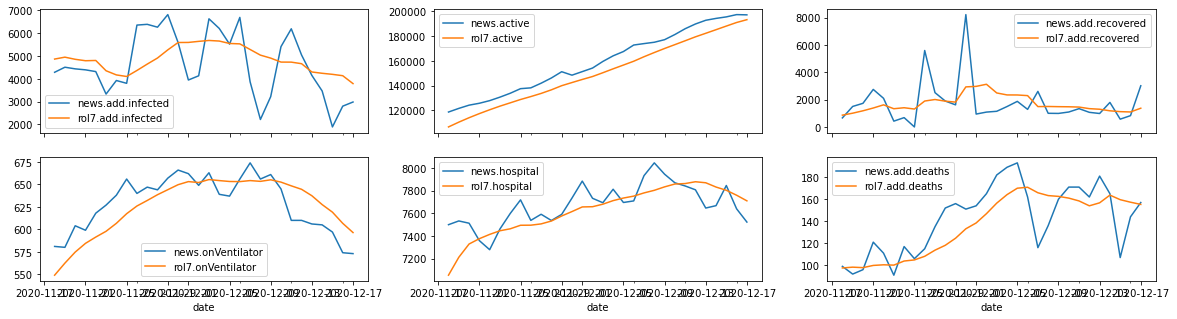

In [22]:
(fig, ax) = plt.subplots(figsize=(20,5), nrows=2, ncols=3, sharex=True)
plot_df = selected_details_df
configuration = {
    "add.infected":(0, 0), "onVentilator":(1,0),   # 1st col
    "active":(0,1),        "hospital":(1,1),       # 2nd col
    "add.recovered":(0,2), "add.deaths":(1,2)      # 3rd col
}
for category in configuration:
    plot_df["rol7.{}".format(category)] = plot_df.rolling(7).mean()[["news.{}".format(category)]]
plot_df = plot_df.reset_index().tail(30)

for (category, position) in configuration.items():
    my_ax = ax[position[0]][position[1]]
    plot_df.plot(x="date", y="news.{}".format(category), ax=my_ax)
    plot_df.plot(x="date", y="rol7.{}".format(category), ax=my_ax)
plt.show()

In [23]:
#plot_df["add.infected"] = plot_df.apply(lambda row: plot_df[plot_df["date"]<], axis=1)
#plot_df.head()
plot_df.head(10)

,date,news.add.infected,news.add.deaths,news.cum.infected,news.cum.recovered,news.onVentilator,news.hospital,news.active,news.add.recovered,rol7.add.infected,rol7.onVentilator,rol7.active,rol7.hospital,rol7.add.recovered,rol7.add.deaths
257,2020-11-18,4290.0,99.0,156949,34846.0,581.0,7499.0,118723.0,661.0,4869.428571,549.000000,106707.142857,7052.857143,862.571429,97.571429
258,2020-11-19,4512.0,92.0,161461,36345.0,580.0,7532.0,121644.0,1499.0,4953.000000,562.428571,110555.714286,7210.857143,1006.142857,98.285714
259,2020-11-20,4440.0,96.0,165901,38074.0,604.0,7512.0,124259.0,1729.0,4859.142857,574.714286,114135.285714,7328.285714,1181.714286,97.857143
260,2020-11-21,4397.0,121.0,170298,40820.0,599.0,7358.0,125789.0,2746.0,4796.428571,584.428571,117447.000000,7375.285714,1384.857143,99.857143
261,2020-11-22,4320.0,111.0,174618,42915.0,618.0,7278.0,127903.0,2095.0,4808.142857,591.428571,120538.142857,7413.142857,1616.571429,100.428571
262,2020-11-23,3334.0,91.0,177952,43339.0,627.0,7461.0,130722.0,424.0,4356.571429,597.857143,123461.857143,7445.285714,1332.714286,100.142857
263,2020-11-24,3929.0,117.0,181881,44020.0,638.0,7598.0,133853.0,681.0,4174.571429,606.714286,126127.571429,7462.571429,1405.000000,103.857143
264,2020-11-25,3806.0,106.0,185687,44020.0,656.0,7718.0,137553.0,0.0,4105.428571,617.428571,128817.571429,7493.857143,1310.571429,104.857143
265,2020-11-26,6360.0,115.0,192047,49616.0,640.0,7537.0,138202.0,5596.0,4369.428571,626.000000,131183.000000,7494.571429,1895.857143,108.142857
266,2020-11-27,6393.0,135.0,198440,52126.0,647.0,7591.0,141950.0,2510.0,4648.428571,632.142857,133710.285714,7505.857143,2007.428571,113.714286


In [24]:
baseDf = pd.read_csv("data/map_data/map_dataframe_per_megye.csv", delimiter=",")[['date','region','confirmed']]
# Convert date column and add week/dayofweek
baseDf['date'] =  pd.to_datetime(baseDf['date'], format='%Y-%m-%d')
baseDf[baseDf["date"].isin(["2020-12-01","2020-12-02","2020-12-03","2020-12-04","2020-12-05"])].pivot(
    index="region",
    columns="date",
    values="confirmed"
)

date,2020-12-01,2020-12-02,2020-12-03,2020-12-04,2020-12-05
region,,,,,
Baranya,5966,6083,6233,6423,6612
Borsod-Abaúj-Zemplén,13496,13733,14098,14387,14604
Budapest,47340,47985,48746,49680,50786
Bács-Kiskun,9719,9908,10177,10534,10759
Békés,6659,6811,7129,7429,7654
Csongrád,9360,9593,9966,10227,10462
Fejér,7469,7579,7859,8098,8279
Győr-Moson-Sopron,14384,14593,14917,15201,15479
Hajdú-Bihar,11900,12122,12544,12992,13335
